# BDV - Recipe analysis

## Imports

In [57]:
from pyspark.sql.functions import round, avg, count, explode, split, col, when, expr
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, VectorIndexer
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.mllib.tree import RandomForest 
from pyspark.ml import Pipeline

spark = SparkSession.builder \
    .master('local[*]') \
    .appName('recipe-analysis') \
    .getOrCreate()
    
spark

## Transform and Load Data

In this segment all data are loaded and tables are prepared so that they can be used for later analyses. The method `convert_time` given here converts the following the given time specifications in the column `TotalTime`, `PrepareTime`, `CookTime` into a uniform minute format. The following formats are possible:

1. `10m`
2. `1h`
3. `1d`
4. `1h 10m`
5. `1d 10m`
6. `1d 10h`
7. `1d 10h 10m`
8. `X`

The method `convert_time` therefore breaks down the time specification into its individual components and converts them. The only exception is the `X`, which is replaced by `0` because no further information is available. 

In the `Recipes` table there is an `Ingredients` column. This contains the ingredients as a serialized array and is therefore not good for analysis. Therefore, a single row is created for each ingredient and the result is saved as a DataFrame.

The `Reviews` table is grouped to get to the cumulative ratings. This means that for each recipe the total rating is calculated and the number of ratings is summed up.

In [58]:
def convert_time(time_column):
    splitted = split(time_column, " ")
    return (
         when(splitted.getItem(1) == "m",
              splitted.getItem(0))
        .when((splitted.getItem(1) == "h") & (splitted.getItem(3) == "m"),
              splitted.getItem(0) * 60 + splitted.getItem(2))
        .when(splitted.getItem(1) == "h",
              splitted.getItem(0) * 60)
        .when((splitted.getItem(1) == "d") & (splitted.getItem(3) == "h") & (splitted.getItem(5) == "m"),
              splitted.getItem(0) * 24 * 60 + splitted.getItem(2) * 60 + splitted.getItem(4))
        .when((splitted.getItem(1) == "d") & (splitted.getItem(3) == "h"), 
              splitted.getItem(0) * 24 * 60 + splitted.getItem(2) * 60)
        .when((splitted.getItem(1) == "d") & (splitted.getItem(3) == "m"), 
              splitted.getItem(0) * 24 * 60 + splitted.getItem(2))
        .when(splitted.getItem(1) == "d", 
              splitted.getItem(0) * 24 * 60)
        .otherwise(0))

recipes = spark\
    .read\
    .option("delimiter", ";")\
    .csv("./data/clean_recipes.csv", header=True, inferSchema=True)\
    .withColumnRenamed("Recipe Name", "RecipeName")\
    .withColumnRenamed("Review Count", "ReviewCount")\
    .withColumnRenamed("Recipe Photo", "RecipePhoto")\
    .withColumnRenamed("Prepare Time", "PrepareTime")\
    .withColumnRenamed("Cook Time", "CookTime")\
    .withColumnRenamed("Total Time", "TotalTime")\
    .withColumn("TotalTimeConverted", convert_time(col("TotalTime")).cast(IntegerType()))\
    .withColumn("CookTimeConverted", convert_time(col("CookTime")).cast(IntegerType()))\
    .withColumn("PrepareTimeConverted", convert_time(col("PrepareTime")).cast(IntegerType()))

reviews = spark\
    .read\
    .option("delimiter", ",")\
    .csv("./data/clean_reviews.csv", header=True, inferSchema=True)

ingredients = recipes.select(explode(split(col("Ingredients"), ",")).alias("Ingredient"), "RecipeID")

best_recipes = reviews\
    .groupBy("RecipeID")\
    .agg(avg("Rate"), count("Rate"))\
    .withColumnRenamed("avg(Rate)", "AvgRate")\
    .withColumnRenamed("count(Rate)", "CountRate")\
    .orderBy("avg(Rate)", ascending=[0])

## Hard Facts

This section lists a few facts about our dataset. The structure of the individual tables can also be seen here.

In [11]:
print(f"recipes.count(): {recipes.count()}")
print(f"reviews.count(): {reviews.count()}")
print(f"ingredients.count(): {ingredients.count()}")

recipes.count(): 12351
reviews.count(): 1563566
ingredients.count(): 102517


In [15]:
recipes.limit(2).toPandas()

recipes(2): 


,RecipeName,ReviewCount,RecipePhoto,Author,PrepareTime,CookTime,TotalTime,Ingredients,Directions,RecipeID,TotalTimeConverted,CookTimeConverted,PrepareTimeConverted
0,Golden Crescent Rolls Recipe,304,https://images.media-allrecipes.com/userphotos...,Mike A.,25 m,15 m,3 h 10 m,"yeast,water,white sugar,salt,egg,butter,flour,...","Dissolve yeast in warm water.**Stir in sugar, ...",7000,190,15,25
1,Poppy Seed Bread with Glaze Recipe,137,https://images.media-allrecipes.com/userphotos...,Christina Jun,15 m,1 h,1 h 20 m,"flour,salt,baking powder,poppy,butter,vegetabl...",'Preheat oven to 350 degrees F (175 degrees C)...,7001,80,60,15


In [13]:
reviews.limit(5).toPandas()

reviews(5): 


,RecipeID,profileID,Rate
0,7000,675719,5.0
1,7000,1478626,5.0
2,7000,608663,5.0
3,7000,2785736,5.0
4,7000,594474,5.0


In [14]:
best_recipes.limit(5).toPandas()

best_recipes.limit(5): 


,RecipeID,AvgRate,CountRate
0,20441,5.000000,30
1,24311,5.000000,1
2,9263,5.000000,30
3,13603,4.966667,30
4,10819,4.965517,29


In [16]:
ingredients.limit(5).toPandas()

,Ingredient,RecipeID
0,yeast,7000
1,water,7000
2,white sugar,7000
3,salt,7000
4,egg,7000


## Research Questions

### 1. Which 10 ingredients are used most often?

Due to our already prepared table `Ingredients`, it is an easy task to group them by the column `Ingredient` count them and sort them by total number.

The result reminded us very much of a German children's song:

Backe, backe Kuchen, \
Der Bäcker hat gerufen. \
Wer will guten Kuchen backen, \
der muss haben sieben Sachen, \
Eier und Schmalz, \
Zucker und Salz, \
Milch und Mehl, \
Safran macht den Kuchen gehl! \
Schieb, schieb in’n Ofen ’nein.

Except for saffron, we have all the ingredients in our list, this may indicate that many cake recipes are used. However, it can be seen from onions and garlic, of course, sour recipes are also represented.

In [30]:
best_ingredients = ingredients\
    .groupBy("Ingredient")\
    .count()\
    .orderBy("count", ascending=[0])\
    .withColumnRenamed("count", "Count")\

best_ingredients.limit(10).toPandas()

,Ingredient,Count
0,white sugar,4986
1,egg,4880
2,salt,4516
3,butter,4456
4,flour,4158
5,vanilla,3111
6,milk,2767
7,onion,2763
8,water,2606
9,garlic,2116


<AxesSubplot:xlabel='Ingredient'>

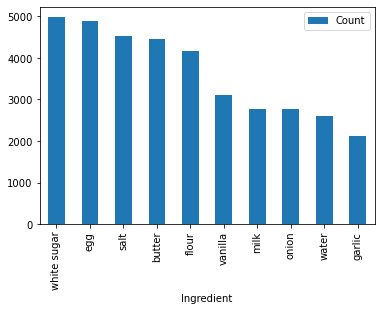

In [33]:
best_ingredients.limit(10).toPandas().plot.bar(x="Ingredient", y="Count")

### 2. Which three ingredients are used most often in the top 10 rated recipes?

First, the top ten recipes with names ingredients, etc. are filtered out. They are joined with the `Ingredients` table so that the frequency of the ingredients is only be counted for the top ten recipes and sorted afterwards.

In [34]:
best_ten_recipes = best_recipes\
    .join(recipes, on="RecipeID", how="inner")\
    .orderBy("AvgRate", ascending=[0])\
    .limit(10)

best_ten_recipes.toPandas()

,RecipeID,AvgRate,CountRate,RecipeName,ReviewCount,RecipePhoto,Author,PrepareTime,CookTime,TotalTime,Ingredients,Directions,TotalTimeConverted,CookTimeConverted,PrepareTimeConverted
0,9263,5.000000,30,Best Boiled Fruitcake Recipe,50,https://images.media-allrecipes.com/userphotos...,Mark Richards,X,X,X,"fruit,cherry,citrus,walnut,butter,spice,baking...",Preheat oven to 325 degrees F (160 degrees C)....,0,0,0
1,24311,5.000000,1,Easy Cinnamon Fudge Recipe,57,https://images.media-allrecipes.com/userphotos...,HANBAN,10 m,10 m,1 h 20 m,"sugar,cocoa powder,cinnamon,butter,milk,vanill...",'Line an 8x8 inch baking pan with aluminum foi...,80,10,10
2,10819,4.965517,29,Ranger Cookies II Recipe,34,https://images.media-allrecipes.com/userphotos...,Rhonda,X,X,X,"shortening,white sugar,brown sugar,egg,vanilla...",Cream shortening with sugars. Beat in egg and...,0,0,0
3,15297,4.964286,28,Special Butterscotch Chip Cookies in a Jar Rec...,50,https://images.media-allrecipes.com/userphotos...,Sally Jo,X,X,X,"flour,baking soda,salt,baking powder,brown sug...",Layer the ingredients in the order given in a ...,0,0,0
4,14305,4.933333,30,Broccoli Salad II Recipe,51,https://images.media-allrecipes.com/userphotos...,Lori J. Sikes,10 m,15 m,25 m,"broccoli,bacon,raisin,mayonnaise,white sugar,w...","Place bacon in a large, deep skillet. Cook ove...",25,15,10
5,24221,4.933333,30,Sex on the Beach III Recipe,48,https://images.media-allrecipes.com/userphotos...,ANG242424,1 m,X,1 m,"vodka,peach,orange juice,cranberry","Fill a highball glass with ice, pour in vodka ...",1,0,1
6,19207,4.933333,30,Sandies Recipe,56,https://images.media-allrecipes.com/userphotos...,Jaimie,4 h 15 m,20 m,4 h 35 m,"butter,white sugar,water,vanilla,flour,pecan,s...","'In a medium bowl, cream together the butter a...",275,20,255
7,7286,4.933333,30,Creme de Menthe Cake I Recipe,49,https://images.media-allrecipes.com/userphotos...,Bonnie,X,X,X,"cake,liqueur,chocolate,topping thawed,liqueur","Prepare 1 box white cake mix as directed, exce...",0,0,0
8,13481,4.933333,30,Cranberry Salad IV Recipe,37,https://images.media-allrecipes.com/userphotos...,Lenna,5 m,X,3 h 5 m,"cranberry,white sugar,whipping cream,marshmall...","In a small bowl, combine the ground cranberrie...",185,0,5
9,8422,4.933333,30,Apple Cake in a Jar Recipe,39,https://images.media-allrecipes.com/userphotos...,Julie Wayment,X,X,X,"shortening,white sugar,egg,cinnamon,nutmeg,sal...","""'Preheat oven to 325 degrees F (165 degrees C...",0,0,0


In [35]:
best_ten_recipes\
    .join(ingredients, on="RecipeID", how="inner")\
    .groupBy("Ingredient")\
    .count()\
    .withColumnRenamed("count", "Count")\
    .orderBy("Count", ascending=[0])\
    .limit(3)\
    .toPandas()

,Ingredient,Count
0,white sugar,7
1,flour,5
2,butter,4


### 3. What is the average total time needed for a recipe?

Here the already prepared `Recipes` with the converted time data are used again. In this case, the entries that have `0` for the `TotalTime` are filtered out in order not to falsify the result. The result gets grouped and then the average value is taken. With the help of Python extensions, the result is converted back into the original time format and output textually.

The median is also calculated in order to exclude any falsification of the result due to outliers. The result shows that, as we will show later, there are outliers with a huge `TotalTime`. The median shows that in reality 50% of the recipes need less than or equal 55 minutes. In comparison, the average is 2h 30m. This clearly shows the outliers.

In [56]:
filtered_recipes = recipes[(recipes.TotalTimeConverted > 0)]

average_time = filtered_recipes\
    .agg(avg("TotalTimeConverted"))\
    .withColumnRenamed("avg(TotalTimeConverted)", "AvgTotalTime")\
    .select("AvgTotalTime")\
    .first()[0]

median_time = filtered_recipes\
    .agg(expr("percentile_approx(TotalTimeConverted, 0.5)").alias("MedianTotalTime"))\
    .select("MedianTotalTime")\
    .first()[0]

print(f"average_time(format HH:MM): {'{:02d}h {:02d}m'.format(*divmod(int(average_time), 60))}")
print(f"median_time(format HH:MM): {'{:02d}h {:02d}m'.format(*divmod(int(median_time), 60))}")

average_time(format HH:MM): 02h 30m
median_time(format HH:MM): 00h 55m


### 4. How good are the 5 recipes with the longest preparation time rated?

For this evaluation we use two already existing tables. First, the `Recipes` table is sorted by the `TotalTimeConverted`. Then the five longest recipes are joined with the ratings, sorted by the average rating and output in table form.

It can be seen that there are recipes that have no rating with two of our five longest recipes this is unfortunately the case. Nevertheless, you can see that a long `TotalTime` is not a guarantee for a good rating, as one of the recipes was rated rather poorly.

In [63]:
five_longest_recipes = recipes\
    .orderBy("TotalTimeConverted", ascending=[0])\
    .limit(5)

five_longest_recipes.toPandas()

,RecipeName,ReviewCount,RecipePhoto,Author,PrepareTime,CookTime,TotalTime,Ingredients,Directions,RecipeID,TotalTimeConverted,CookTimeConverted,PrepareTimeConverted
0,Noel Fruitcake Recipe,2,https://images.media-allrecipes.com/userphotos...,JJOHN32,30 m,3 h 30 m,30 d 4 h,"flour,baking powder,salt,cinnamon,clove,raisin...",Preheat oven to 300 degrees F (150 degrees C)....,8470,43440,210,30
1,Thirty Day Friendship Cake Recipe,60,https://images.media-allrecipes.com/userphotos...,Yvonne,1 h,1 h,30 d 2 h,"fruit,peach,white sugar,pineapple,white sugar,...","'Day One: In a large glass jar or bowl, combin...",7900,43320,60,60
2,Pickled Garlic Recipe,28,https://images.media-allrecipes.com/userphotos...,Brenda Kraneveldt,45 m,15 m,21 d 1 h,"garlic,bell pepper,vinegar,white sugar,mustard...","Place garlic cloves in a medium bowl, first cu...",25544,30300,15,45
3,Homemade Vanilla Recipe,33,https://images.media-allrecipes.com/userphotos...,GINGER P,5 m,X,20 d 20 h,"vodka,vanilla",Submerge vanilla beans in vodka and store in a...,19810,30000,0,5
4,Rock Candy Recipe,40,https://images.media-allrecipes.com/userphotos...,Amanda Rader,20 m,X,10 d 10 h,"water,white sugar","""Prepare your candy growing area by thoroughly...",24056,15000,0,20


In [72]:
five_longest_recipes\
    .join(best_recipes, on="RecipeID", how="left")\
    .select("RecipeID", "RecipeName", "AvgRate", "CountRate", "TotalTime", "TotalTimeConverted")\
    .orderBy("AvgRate", ascending=[0])\
    .toPandas()

,RecipeID,RecipeName,AvgRate,CountRate,TotalTime,TotalTimeConverted
0,7900,Thirty Day Friendship Cake Recipe,4.525424,59.0,30 d 2 h,43320
1,19810,Homemade Vanilla Recipe,4.300000,30.0,20 d 20 h,30000
2,24056,Rock Candy Recipe,2.833333,30.0,10 d 10 h,15000
3,8470,Noel Fruitcake Recipe,NaN,NaN,30 d 4 h,43440
4,25544,Pickled Garlic Recipe,NaN,NaN,21 d 1 h,30300


### 5. Can we predict how good the rating will be based on the ingredients and preparation time?

#### Experiment - Linear Regression

In the first step the required tables are merged and the textual columns are converted to numeric columns using `StringIndexer`. The data is also cleaned. This means that the entries that do not have a total for the time will be sorted out.

In [76]:
ml_recipes = ingredients\
    .groupBy("RecipeID")\
    .agg(count("RecipeID"))\
    .withColumnRenamed("count(RecipeId)", "CountIngredients")\
    .join(recipes, on="RecipeID", how="inner")\
    .join(best_recipes, on="RecipeID", how="inner")

filtered_ml_recipes = ml_recipes[(ml_recipes.TotalTimeConverted > 0)]
filtered_ml_recipes = filtered_ml_recipes[(filtered_ml_recipes.CookTimeConverted > 0)]
filtered_ml_recipes = filtered_ml_recipes[(filtered_ml_recipes.PrepareTimeConverted > 0)]

author_indexer = StringIndexer(inputCol="Author", outputCol="AuthorIndex")
filtered_ml_recipes = author_indexer.fit(filtered_ml_recipes).transform(filtered_ml_recipes)

The next step is to create a feature vector. This means that all columns relevant for us are combined into one feature vector. This requires a `VectorAssembler` in `PySpark`.

In [81]:
trimmed_ml_recipes = filtered_ml_recipes[["CountIngredients", "AuthorIndex", "TotalTimeConverted",\
    "CookTimeConverted", "PrepareTimeConverted", "AvgRate"]]

assembler = VectorAssembler(inputCols=["CountIngredients", "AuthorIndex", "TotalTimeConverted",\
   "CookTimeConverted", "PrepareTimeConverted"], outputCol="Features")
prepared_ml_recipes = assembler.transform(trimmed_ml_recipes)

prepared_ml_recipes\
    .limit(5)\
    .toPandas()

,CountIngredients,AuthorIndex,TotalTimeConverted,CookTimeConverted,PrepareTimeConverted,AvgRate,Features
0,18,238.0,165,50,25,4.400000,"[18.0, 238.0, 165.0, 50.0, 25.0]"
1,4,2198.0,30,5,10,4.362069,"[4.0, 2198.0, 30.0, 5.0, 10.0]"
2,8,2102.0,95,20,45,4.357143,"[8.0, 2102.0, 95.0, 20.0, 45.0]"
3,11,95.0,90,70,20,4.483333,"[11.0, 95.0, 90.0, 70.0, 20.0]"
4,7,447.0,45,30,15,4.449367,"[7.0, 447.0, 45.0, 30.0, 15.0]"


In [82]:
scaler = StandardScaler(inputCol="Features", outputCol="ScaledFeatures")
prepared_ml_recipes = scaler.fit(prepared_ml_recipes).transform(prepared_ml_recipes)
prepared_ml_recipes.limit(5).toPandas()

,CountIngredients,AuthorIndex,TotalTimeConverted,CookTimeConverted,PrepareTimeConverted,AvgRate,Features,ScaledFeatures
0,18,238.0,165,50,25,4.400000,"[18.0, 238.0, 165.0, 50.0, 25.0]","[5.248010563301311, 0.27368204995331613, 0.202..."
1,4,2198.0,30,5,10,4.362069,"[4.0, 2198.0, 30.0, 5.0, 10.0]","[1.1662245696225135, 2.5275342260394487, 0.036..."
2,8,2102.0,95,20,45,4.357143,"[8.0, 2102.0, 95.0, 20.0, 45.0]","[2.332449139245027, 2.4171414663944137, 0.1163..."
3,11,95.0,90,70,20,4.483333,"[11.0, 95.0, 90.0, 70.0, 20.0]","[3.2071175664619123, 0.10924283506539928, 0.11..."
4,7,447.0,45,30,15,4.449367,"[7.0, 447.0, 45.0, 30.0, 15.0]","[2.0408929968393985, 0.5140162870971945, 0.055..."


As announced, linear regression is used here to predict the average rating for a recipe.

In [83]:
lr_train, lr_test = prepared_ml_recipes.randomSplit([.8,.2], seed=0)
lr = LinearRegression(featuresCol="ScaledFeatures", labelCol="AvgRate")

lrModel = lr.fit(lr_train)
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

lrTrainingSummary = lrModel.summary
print("numIterations: %d" % lrTrainingSummary.totalIterations)
print("objectiveHistory: %s" % str(lrTrainingSummary.objectiveHistory))
print("RMSE: %f" % lrTrainingSummary.rootMeanSquaredError)
print("r2: %f" % lrTrainingSummary.r2)

Coefficients: [0.03320920724233807,0.006665368183540895,0.0014521408890168098,-0.020730343450626024,0.012258345234240558]
Intercept: 4.325013715772024
numIterations: 1
objectiveHistory: [0.0]
RMSE: 0.299593
r2: 0.019334


#### Evaluation - Linear Regression

The poor results do not seem too bad when you look at them, but when you compare the standard deviation with our deviation, you see that both are almost equal. This is also the reason why this result is rated so poorly. More details can be found in the following evaluation:

In [86]:
prepared_ml_recipes.agg({'AvgRate': 'stddev'}).toPandas()

,stddev(AvgRate)
0,0.301017


In [87]:
lr_predictions = lrModel.transform(lr_test)
lr_predictions.select(['prediction', 'AvgRate', 'Features']).limit(5).toPandas()

,prediction,AvgRate,Features
0,4.402284,4.500000,"[6.0, 2126.0, 65.0, 45.0, 20.0]"
1,4.425020,4.560582,"[10.0, 457.0, 60.0, 45.0, 15.0]"
2,4.422400,4.480000,"[10.0, 751.0, 285.0, 40.0, 5.0]"
3,4.525703,4.400000,"[19.0, 1950.0, 70.0, 50.0, 20.0]"
4,4.424450,4.583333,"[6.0, 1245.0, 90.0, 30.0, 60.0]"


In [88]:
lr_evaluator = RegressionEvaluator(predictionCol="prediction",\
    labelCol="AvgRate", metricName="r2")

print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.0272771


#### Experiment - Random Forest

Due to the not so good results of our first experiment, we still wanted to try if maybe there is no linear relationship in our data. Therefore, we wanted to try a different approach to see if there was a different relationship in our data. For this we decided to use `RandomForest`. This is a combination of several decision trees.

In [93]:
featureIndexer = VectorIndexer(inputCol="ScaledFeatures", outputCol="IndexedFeatures", maxCategories=4)\
    .fit(prepared_ml_recipes)

In [94]:
rf_train, rf_test = prepared_ml_recipes.randomSplit([0.7, 0.3], seed=0)
rf = RandomForestRegressor(featuresCol="IndexedFeatures", labelCol="AvgRate", numTrees=3, 
    featureSubsetStrategy="auto", impurity='variance', maxDepth=4, maxBins=4029)
rf_pipeline = Pipeline(stages=[featureIndexer, rf])

rf_model = rf_pipeline.fit(rf_train)

Unfortunately, the result shows that even with `RandomForest` no better result can be achieved. With more time, one could perhaps achieve a higher accuracy with an elaborate transformation of the ingredients. Unfortunately, this was beyond the scope of this project and therefore we stayed with this result.

In [97]:
rf_predictions = rf_model.transform(rf_test)

rf_predictions.select("prediction", "AvgRate", "Features").limit(5).toPandas()

rf_evaluator = RegressionEvaluator(labelCol="AvgRate", predictionCol="prediction", metricName="r2")
print("R Squared (R2) on test data = %g" % rf_evaluator.evaluate(rf_predictions))
print(rf_model.stages[1])

R Squared (R2) on test data = 0.00136562
RandomForestRegressionModel: uid=RandomForestRegressor_b7d8c895d2be, numTrees=3, numFeatures=5
